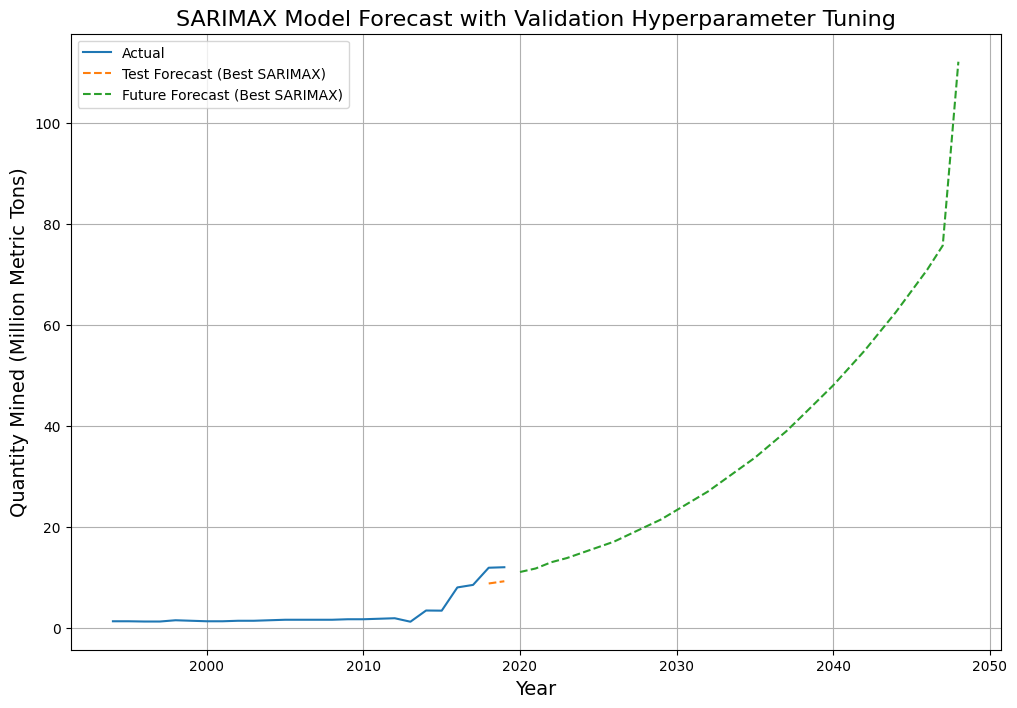

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
import itertools
import warnings
warnings.filterwarnings("ignore")

# Data preparation
data = {
    "Year": [1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050],
    "GDP (in Trillion USD)": [0.32727, 0.36028, 0.39290, 0.41587, 0.42135, 0.45882, 0.46840, 0.48544, 0.51494, 0.60770, 0.70915, 0.82038, 0.94026, 1.19890, 1.21674, 1.34189, 1.67562, 1.823, 1.827, 1.856, 2.039, 2.103, 2.294, 2.651, 2.702, 2.835, 2.675, 3.167, 3.353, 3.550, 3.889, 4.1, 4.4, 4.7, 5.0, 5.4, 5.8, 6.2, 6.7, 7.2, 7.7, 8.3, 8.9, 9.5, 10.2, 10.9, 11.7, 12.5, 13.3, 14.2, 15.1, 16.1, 17.1, 18.2, 19.3, 20.5, 30.0],
    "Population (Billion)": [0.945, 0.964, 0.983, 1.002, 1.021, 1.040, 1.060, 1.079, 1.098, 1.117, 1.136, 1.155, 1.172, 1.190, 1.207, 1.224, 1.241, 1.261, 1.279, 1.296, 1.312, 1.328, 1.344, 1.36, 1.375, 1.383, 1.396, 1.407, 1.417, 1.428, 1.441, 1.437, 1.452, 1.467, 1.482, 1.497, 1.512, 1.527, 1.542, 1.557, 1.572, 1.587, 1.602, 1.617, 1.632, 1.647, 1.662, 1.667, 1.672, 1.677, 1.682, 1.687, 1.692, 1.697, 1.702, 1.658, 1.668],
    "Sand and Gravel Mining (in Million Metric Ton)": [1.3, 1.3, 1.25, 1.25, 1.5, 1.4, 1.3, 1.3, 1.4, 1.4, 1.5, 1.6, 1.6, 1.6, 1.6, 1.7, 1.7, 1.8, 1.9, 1.21, 3.43, 3.4, 8.0, 8.5, 11.9, 12, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan]
}
df = pd.DataFrame(data)
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.set_index('Year', inplace=True)

# Splitting the data
train = df.iloc[:23]           # 1994–2016 (21 years)
validation = df.iloc[23:24]    # 2017 (1 year for validation)
test = df.iloc[24:26]          # 2018–2019 (4 years for test)
forecast_period = df.iloc[26:] # 2020 and beyond

# Exogenous variables
exog_train = train[['GDP (in Trillion USD)', 'Population (Billion)']]
exog_validation = validation[['GDP (in Trillion USD)', 'Population (Billion)']]
exog_test = test[['GDP (in Trillion USD)', 'Population (Billion)']]
exog_forecast = forecast_period[['GDP (in Trillion USD)', 'Population (Billion)']]

# Hyperparameter tuning using validation set
p = d = q = range(0, 3)
P = D = Q = range(0, 2)
s = 2  # seasonal period

pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, [s]))

best_mae = float('inf')
best_order = None
best_seasonal_order = None

for order in pdq:
    for seasonal_order in seasonal_pdq:
        try:
            model = SARIMAX(train['Sand and Gravel Mining (in Million Metric Ton)'],
                            exog=exog_train,
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
            model_fit = model.fit(disp=False)
            forecast = model_fit.forecast(steps=1, exog=exog_validation)
            mae = mean_absolute_error(validation['Sand and Gravel Mining (in Million Metric Ton)'], forecast)

            if mae < best_mae:
                best_mae = mae
                best_order = order
                best_seasonal_order = seasonal_order

        except:
            continue

# Refit the model on train + validation
train_val = pd.concat([train, validation])
exog_train_val = pd.concat([exog_train, exog_validation])

final_model = SARIMAX(train_val['Sand and Gravel Mining (in Million Metric Ton)'],
                      exog=exog_train_val,
                      order=best_order,
                      seasonal_order=best_seasonal_order,
                      enforce_stationarity=False,
                      enforce_invertibility=False)
final_model_fit = final_model.fit()

# Forecast on test
test_forecast = final_model_fit.forecast(steps=len(test), exog=exog_test)
test_forecast = pd.Series(test_forecast, index=test.index)

# Forecast on future
final_forecast = final_model_fit.forecast(steps=len(forecast_period), exog=exog_forecast)
final_forecast = pd.Series(final_forecast, index=forecast_period.index)

# Plotting results
plt.figure(figsize=(12, 8))
plt.plot(df.index, df['Sand and Gravel Mining (in Million Metric Ton)'], label='Actual')
plt.plot(test.index, test_forecast, label='Test Forecast (Best SARIMAX)', linestyle='--')
plt.plot(forecast_period.index, final_forecast, label='Future Forecast (Best SARIMAX)', linestyle='--')
plt.xlabel("Year", fontsize=14)
plt.ylabel("Quantity Mined (Million Metric Tons)", fontsize=14)
plt.title("SARIMAX Model Forecast with Validation Hyperparameter Tuning", fontsize=16)
plt.legend()
plt.grid(True)
plt.show()
